# Setup

In [44]:
!pip install datasets ultralytics

In [45]:
from pathlib import Path

In [46]:
def create_dirs():
    current_dir = Path.cwd()

    subdirs = [current_dir / name for name in ("saved_models",)]

    for subdir in subdirs:
        if not subdir.is_dir():
            print(f"Directory '{subdir}' not found. Creating it...")
            subdir.mkdir(parents=True)
            print(f"Created!")

def download_model():
    import requests
    import zipfile
    import os
    from time import sleep

    url = "https://www.dropbox.com/scl/fi/qv696uvyukgwekbkdyadg/saved_model.zip?rlkey=pvv20e86ipcxlrjakcl4pwsgz&st=d5kfkudc&dl=0"
    # download model from Dropbox
    try:
        os.system(f"wget -O saved_model.zip {url}")
    except Exception as e:
        print(f"Exception occurred: {e}.")
        if (Path.is_file("saved_model.zip")):
            print("Deleting partially downloaded file...")
            os.remove("saved_model.zip")

    sleep(10)
    with zipfile.ZipFile("saved_model.zip", "r") as zip_ref:
        zip_ref.extractall(model_base_dir)

    os.remove("saved_model.zip")

def setup():
    create_dirs()

    if not model_base_dir.exists() or not any(model_base_dir.iterdir()):
        print("Model not found. Downloading it...")
        download_model()
        print("Downloaded!")

def remove_setup():
    import shutil
    if model_base_dir.exists():
        shutil.rmtree(model_base_dir)
        print(f"Removed directory: {model_base_dir}")
    else:
        print(f"Directory {model_base_dir} does not exist. Nothing to remove.")

model_base_dir = Path.cwd() / "saved_models" / "yolo11n_on_vehicleDatasetForYolo"
load_model_dir = model_base_dir / "yolo11n_saved_model"

# remove setup
# remove_setup()

setup()

Directory /content/saved_models/yolo11n_on_vehicleDatasetForYolo does not exist. Nothing to remove.
Model not found. Downloading it...
Downloaded!


# Execution

In [47]:

from datasets import load_dataset

raw_dataset = load_dataset("ilsilfverskiold/traffic-camera-norway-images")


In [55]:
import numpy as np
from PIL import Image
import tensorflow as tf
import numpy as np

# Cargar modelo
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO(load_model_dir, task= 'detect')
model.conf = 0.7
# model.iou = 0.1

Randomly sampling 15 images from validation dataset...
Got 15 images!


Running inference on 15 images...:   0%|          | 0/15 [00:00<?, ?it/s]

Loading /content/saved_models/yolo11n_on_vehicleDatasetForYolo/yolo11n_saved_model for TensorFlow SavedModel inference...


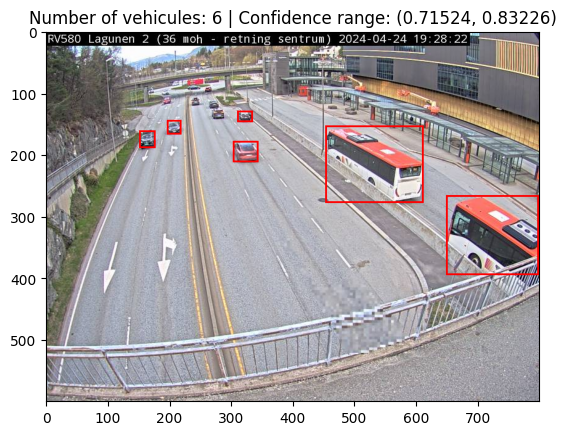

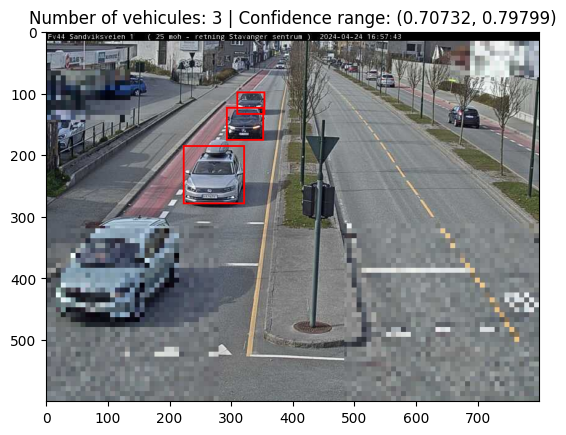

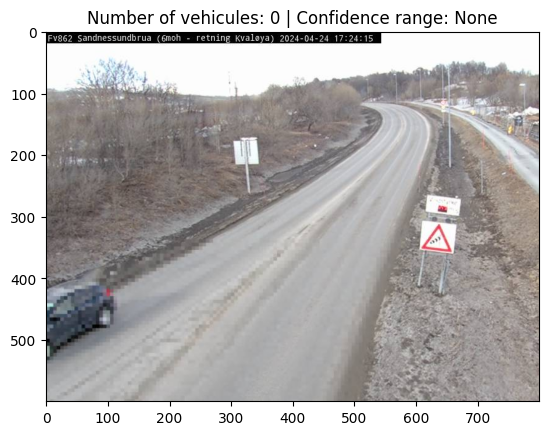

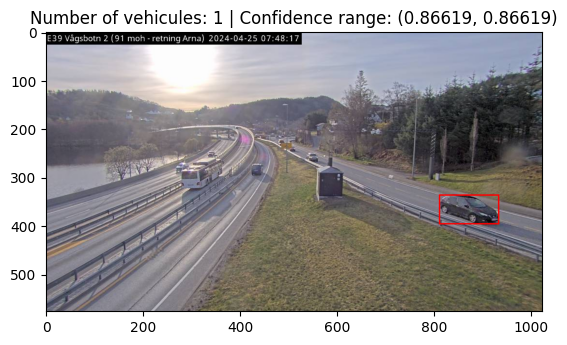

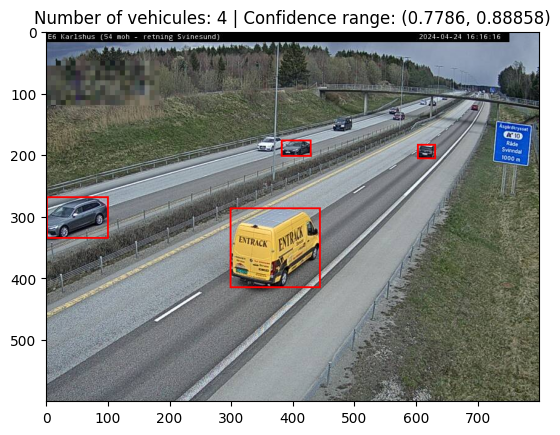

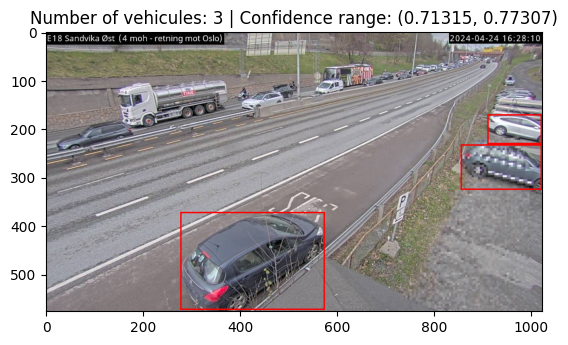

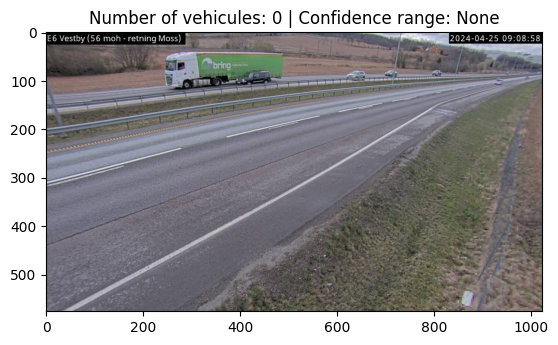

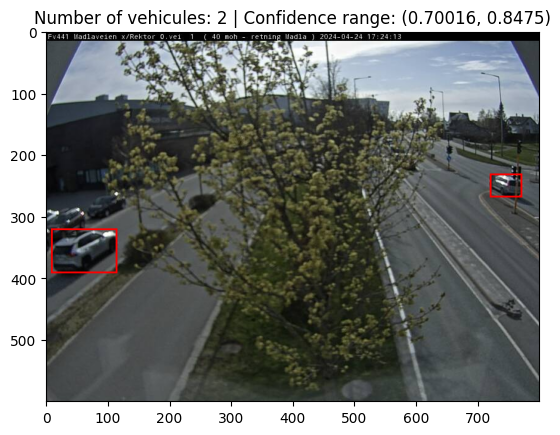

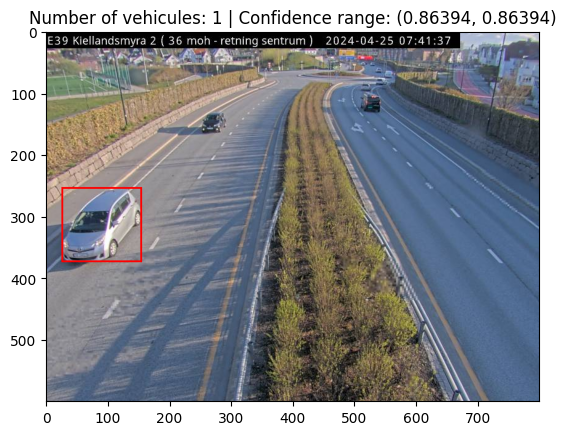

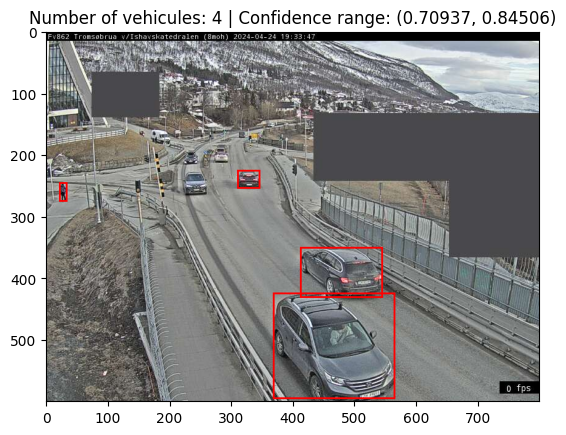

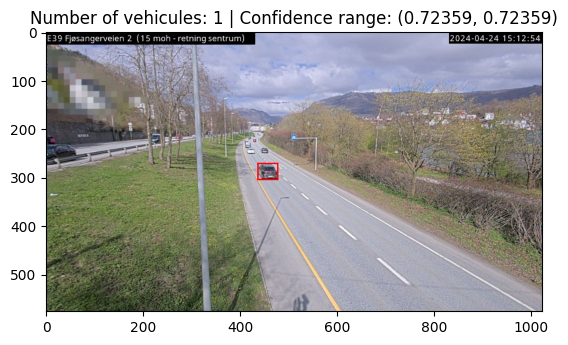

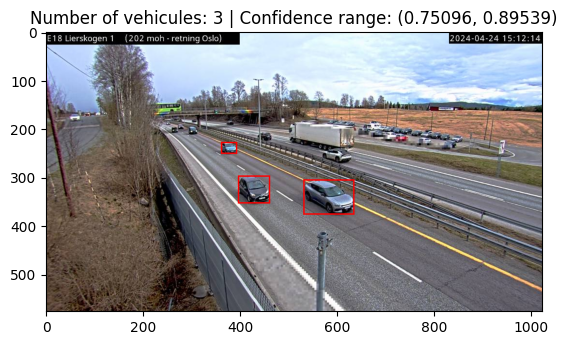

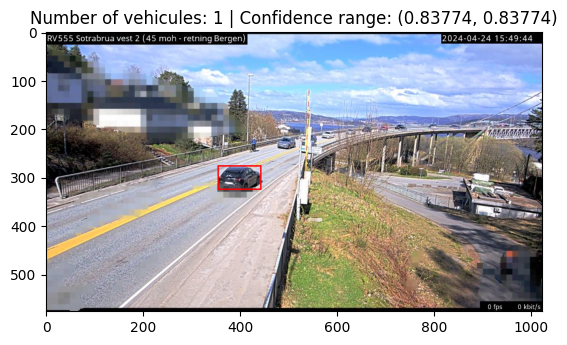

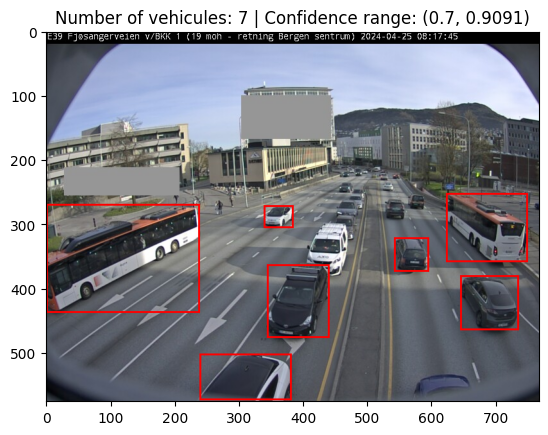

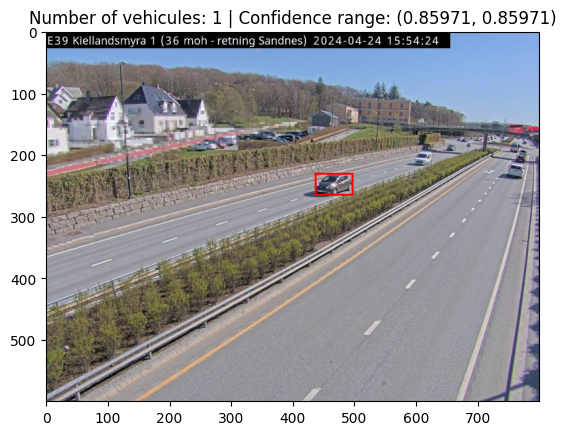

In [57]:
from PIL import Image, ImageDraw, ImageFilter
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import random

# randomly choose images
num_samples = 15
print(f"Randomly sampling {num_samples} images from validation dataset...")
images = random.sample(raw_dataset['validation']['image'], num_samples)
print(f"Got {len(images)} images!")

for i, image in enumerate(tqdm(images, f"Running inference on {len(images)} images...", leave=True)):
    # Apply a blur to the image
    image = image.filter(ImageFilter.GaussianBlur(radius=0))

    draw = ImageDraw.Draw(image)

    results = model(image, verbose=False)[0].to_df()

    if results.empty:
        print(f"No objects detected in image {i}.")
    else:
        # Filter using the minimum confidence of the model (the threshold)
        results = results[results["confidence"] >= model.conf]

        boxes = results["box"].values
        conf = results["confidence"].values
        classes = results["class"].values
        index_list = [2,3,5,7]

        # Draw matches
        for box in boxes:
            xmin, ymin, xmax, ymax = box.values()
            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline = 'red', width=3)

    array_image = np.array(image)

    num_objects = len(boxes) if len(results) != 0 else 0
    confidence_range = (float(conf.min()), float(conf.max())) if len(results) != 0 else None

    # Create a new figure for each image and show it
    plt.figure()
    plt.title(f'Number of vehicules: {num_objects} | Confidence range: {confidence_range}')
    plt.imshow(array_image)